# Notebook to test loading the aggregated references

In [4]:
import sys

#Ensure latest version of fsspec is used to allow simpletemplate=True of reference file system
sys.path.insert(0,'/home/jovyan/filesystem_spec')

In [5]:
import fsspec
import xarray as xr
import os, glob
# xr.set_options(display_style='text')

In [6]:
fsspec.__file__

'/home/jovyan/filesystem_spec/fsspec/__init__.py'

In [7]:
gateway_cluster = False
from dask.distributed import Client, LocalCluster
from dask_gateway import Gateway

# Dask gateway
if gateway_cluster:
    gateway = Gateway()
    clusters = gateway.list_clusters()
    if not clusters:
        print('Creating new cluster. Please wait for this to finish.')
        cluster = gateway.new_cluster()
    else:
        print(f'An existing cluster was found. Connected to cluster \033[1m{clusters[0].name}\033[0m')
        cluster=gateway.connect(clusters[0].name)
    cluster.adapt(minimum=1, maximum=30)
    client = cluster.get_client()
    client.wait_for_workers(n_workers=1)

# Local cluster
else:
    cluster = LocalCluster()
    client = Client(cluster)

display(cluster)
display(client)

Client Scheduler: tcp://127.0.0.1:34393 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 32 Memory: 30.06 GB


## Opening the full stack in a delayed fashion is too slow (too many chunks for dask to compose) - need to subset and load each month using a different (single) thread

In [13]:
def open_and_crop(fo,key,secret,data_vars=['sea_surface_temperature','l2p_flags'],cropto=dict(lat=slice(-32.0,-32.5),lon=slice(115.0,115.5)),load=True,simple_templates=True):
    
    so = dict(
        target_protocol='s3',
        target_options=dict(key=key,secret=secret),
        remote_protocol='s3',
        remote_options=dict(key=key,secret=secret),
        simple_templates=simple_templates,
        fo=fo
    )
    ds = xr.open_dataset('reference://',
                     engine='zarr',
                     storage_options=so,
                     chunks={'time':14})
    

    ds = ds[data_vars]
    ds = ds.sel(**cropto)
    
    #Loading the data at this point causes issues with dask, due to task nesting - works OK using single-threaded, which makes sense
    if load:
        import dask
        with dask.config.set(scheduler='single-threaded'):
            try:
                ds = ds.load() #loads this months data
            except Exception as ex:
                print('Load Failed: ' + fn)
                return None
    
    return ds

In [14]:
def open_stack(s3_path,open_func=open_and_crop,open_kwargs={}):
    from dask import compute, delayed
        
    agg_files = fs.glob(s3_path + '/*.json')
    
#     agg_files = agg_files[0:50]
    
    d_open_dataset = delayed(open_func)
    futures = []
    for f in agg_files:
        futures.append(d_open_dataset(f,**open_kwargs))
    dsets = compute(futures)[0]
    
    for i,ds in enumerate(dsets):
        if ds is None:
            print('Failed to open: ' + agg_files[i])
            
    dsets = [ds for ds in dsets if ds is not None]
    
    xarray_concat_kwargs = dict(dim='time',coords='minimal',join='override',compat='override',combine_attrs='override')
    ds = xr.concat(dsets, **xarray_concat_kwargs)
    ds = ds.sortby('time') # The sort is beneficial to re-order the data according to the coordinate, as having separate stacks for the different layouts breaks the ordering.
    
    return ds

In [15]:
# Load credentials
def load_creds():
    with open(os.environ['HOME'] + '/.aws/credentials','rt') as f:
        f.readline()
        key=f.readline().split('=')[1].strip()
        secret=f.readline().split('=')[1].strip()
    return key, secret
key,secret=load_creds()

### Monthly aggregates - load eagerly

In [30]:
%%time
fs = fsspec.filesystem('s3',profile='default')
ds = open_stack('imos-data-pixeldrill-refs/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/agg_monthly/',
                open_func=open_and_crop,
                open_kwargs=dict(key=key,secret=secret,load=True,simple_templates=True))

CPU times: user 8.65 s, sys: 821 ms, total: 9.47 s
Wall time: 1min 9s


### Monthly aggregates - open delayed and load distributed - slower

In [21]:
%%time
ds = open_stack('imos-data-pixeldrill-refs/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/agg_monthly/',
                open_func=open_and_crop,
                open_kwargs=dict(key=key,secret=secret,load=False,simple_templates=True))
ds = ds.chunk({'time':28})
# The graph is big, so takes the notebook and scheduler time to move around, much quicker to load eagerly the small payload
ds = ds.load()

CPU times: user 36.6 s, sys: 1.75 s, total: 38.3 s
Wall time: 1min 38s


### Yearly aggregates - load eagerly
NOTE: fails with simple_templates=True...not sure why - makes it slower than monthly

In [29]:
### This is failing....
# %%time
# fs = fsspec.filesystem('s3',profile='default')
# ds = open_stack('imos-data-pixeldrill-refs/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/agg_yearly/',
#                 open_func=open_and_crop,
#                 open_kwargs=dict(key=key,secret=secret,load=True,simple_templates=False))

UsageError: Line magic function `%%time` not found.
distributed.nanny - WARNING - Restarting worker


In [31]:
ds

<xarray.Dataset>
Dimensions:                  (lat: 25, lon: 25, time: 10577)
Coordinates:
  * lat                      (lat) float32 -32.01 -32.03 ... -32.47 -32.49
  * lon                      (lon) float32 115.0 115.0 115.1 ... 115.5 115.5
  * time                     (time) datetime64[ns] 1992-03-21T15:20:00 ... 20...
Data variables:
    sea_surface_temperature  (time, lat, lon) float32 nan nan ... 291.3 290.6
    l2p_flags                (time, lat, lon) float32 nan nan ... 8.192e+03
Attributes: (12/50)
    Conventions:                      CF-1.6
    Metadata_Conventions:             Unidata Dataset Discovery v1.0
    Metadata_Link:                    TBA
    acknowledgment:                   Any use of these data requires the foll...
    cdm_data_type:                    grid
    comment:                          HRPT AVHRR experimental L3 retrieval pr...
    ...                               ...
    summary:                          Skin SST retrievals produced from stitc...
    time_coverage_end:                19920321T141620Z
    time_coverage_start:              19920321T055557Z
    title:                            IMOS L3S Nighttime gridded multiple-sen...
    uuid:                             1f323c53-8d93-4bb4-a633-49622aa4e497
    westernmost_longitude:            70.01000213623047

In [33]:
ds.nbytes/1E6

52.969816

In [34]:
ds_stacked = ds.stack(space=['lon','lat'])

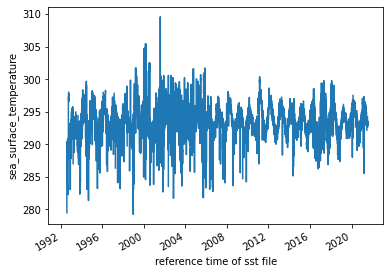

In [35]:
ds_stacked.sea_surface_temperature.mean(dim='space').plot()